In [1]:
import warnings
from math import sqrt
from pandas import read_csv
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import pandas as pd

In [2]:
df_train = read_csv("train_data.csv")
df_train.columns = ["date", "petrol_price"]
df_train["date"] = to_datetime(df_train["date"])
df_train.set_index("date", inplace = True)
df_train = df_train.fillna(method = "ffill")
df_train.isnull().any()

df_test = read_csv("test_data.csv")
df_test.columns = ["date", "prediction"]
df_test["date"] = to_datetime(df_test["date"])

<AxesSubplot: xlabel='date'>

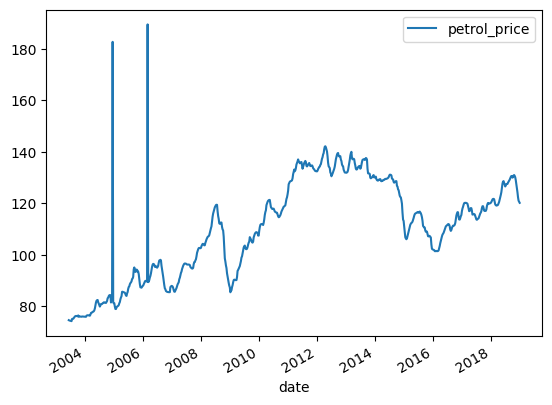

In [3]:
df_train.plot()

In [4]:
# stationarity test class
# check for stationarity using the unit root test i.e Augmented Dickey fuller test
# H0 - Null hypothesis - p-value > 0.05, the data has a unit root and is non-stationary.
# H1 - Alternate Hypothesis - p-value <= 0.05 , the data does not have a unit root and is stationary

class StationarityTest:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    
    def ADF_Test(self, timeseries):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used']
        dfResults = pd.Series(adfTest[0:4], index = index)

            #Add Critical Values
        for key,value in adfTest[4].items():
            dfResults['Critical Value (%s)'%key] = value

        print('Augmented Dickey-Fuller Test Results:')
        print(dfResults)

In [5]:
# stationarity Test results
sTest = StationarityTest()
sTest.ADF_Test(df_train["petrol_price"])
print("Is the time series stationary? {}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.040100
P-Value                   0.269272
# Lags Used               6.000000
# Observations Used     806.000000
Critical Value (1%)      -3.438489
Critical Value (5%)      -2.865133
Critical Value (10%)     -2.568683
dtype: float64
Is the time series stationary? False


In [6]:
# as we have find out that the data is not stationary , we have to do the differencing shift
#differencing
df_train["first_difference"] = df_train["petrol_price"] - df_train["petrol_price"].shift(periods = 1)
df_diff = df_train.fillna(method='ffill')
df_diff

,petrol_price,first_difference
date,,
2003-06-09,74.59,NaN
2003-06-16,74.47,-0.12
2003-06-23,74.42,-0.05
2003-06-30,74.35,-0.07
2003-07-07,74.28,-0.07
...,...,...
2018-12-03,124.30,-1.47
2018-12-10,122.37,-1.93
2018-12-17,121.02,-1.35


In [7]:
#check again after differencing
sTest = StationarityTest()
sTest.ADF_Test(df_diff["first_difference"].dropna())
print("Is the time series stationary? {}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.659974e+01
P-Value                 1.768847e-29
# Lags Used             5.000000e+00
# Observations Used     8.060000e+02
Critical Value (1%)    -3.438489e+00
Critical Value (5%)    -2.865133e+00
Critical Value (10%)   -2.568683e+00
dtype: float64
Is the time series stationary? True


<AxesSubplot: xlabel='date'>

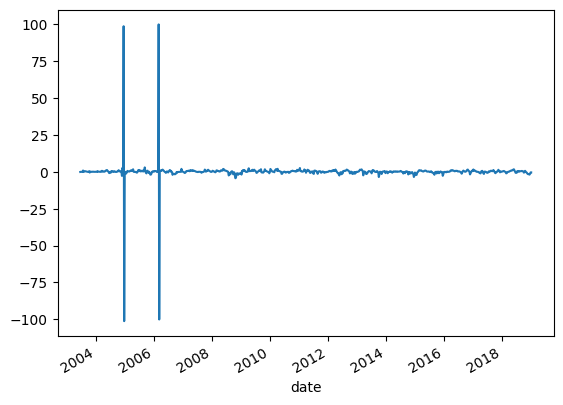

In [8]:
df_diff["first_difference"].plot()
# hyperparameter value, d = 1 as we are differencing it only one step
# constant mean
# constant standard deviation
# no seasionality
# that meand the data is stastionary , now we can use the data for pridicting the future

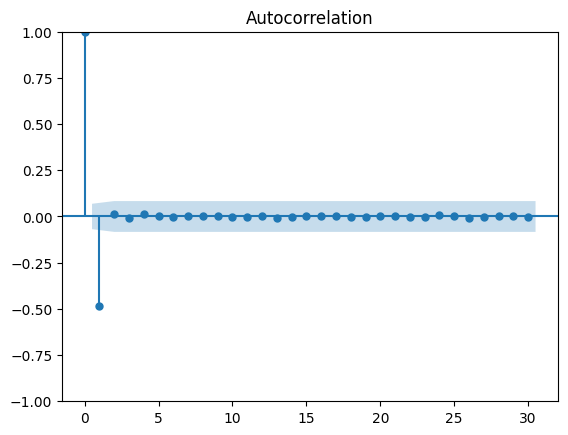

In [9]:
acf_plot = plot_acf(df_diff["first_difference"].dropna())
# as we can see at q = 1 , q is statisticall significant and hignly correlated 
# for moving average model , our order = 1

D:\python\petrol_price\venv\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


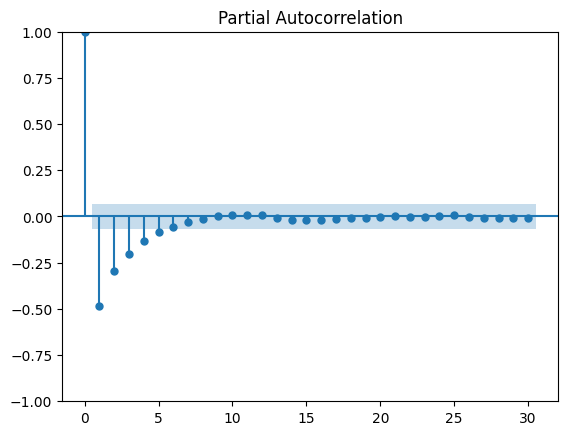

In [10]:
pacf_plot = plot_pacf(df_diff["first_difference"].dropna())
# as we can see at p = 1 , p is stastically significant and higly correlated
# so for our auto regressive model , order = 1

In [11]:
model = pm.auto_arima(df_train["petrol_price"],
                         m = 12, seasonal = True,
                         start_p = 0, start_q = 0,
                         max_p = 4, max_d = 1, max_q = 1,
                         max_order = None , test = "adf",
                         error_action = "ignore", 
                         suppress_wornings = True, 
                         stepwise = True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=5487.790, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5483.790, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5270.593, Time=1.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5142.083, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5481.841, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5140.232, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5142.083, Time=0.65 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5144.083, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5141.514, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5268.609, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=5139.237, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=5141.118, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=5141.118, Time=0.44 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=5143.118, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0

In [12]:
model.fit(df_train["petrol_price"])

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  813
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2567.618
Date:                Mon, 28 Nov 2022   AIC                           5139.237
Time:                        19:55:08   BIC                           5148.636
Sample:                             0   HQIC                          5142.845
                                - 813                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7053      0.007    -98.300      0.000      -0.719      -0.691
sigma2        32.6373      0.152    215.317      0.000      32.340      32.934
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):           1748772.73
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            12.36
Prob(H) (two-sided):                  0.00   Kurtosis:                       229.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
forecast = model.predict(n_periods = 16)
forecast_df = pd.DataFrame(forecast, columns = ["prediction"])
forecast_df.set_index(df_test["date"],inplace = True)
forecast_df

D:\python\petrol_price\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,prediction
date,
2019-01-01,122.318782
2019-01-02,122.318782
2019-01-03,122.318782
2019-01-04,122.318782
2019-01-05,122.318782
2019-01-06,122.318782
2019-01-07,122.318782
2019-01-08,122.318782
2019-01-09,122.318782


<AxesSubplot: xlabel='date'>

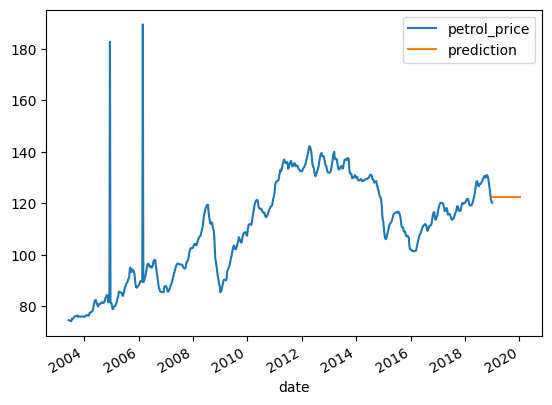

In [15]:
pd.concat([df_train["petrol_price"], forecast_df], axis = 1).plot()

In [16]:
import pickle
filename = "petrol_price.pkl"
pickle.dump(model, open(filename,"wb"))